Предварительная обработка и визуализация данных

Train data: (499062, 7)
Test data: (176451, 7)


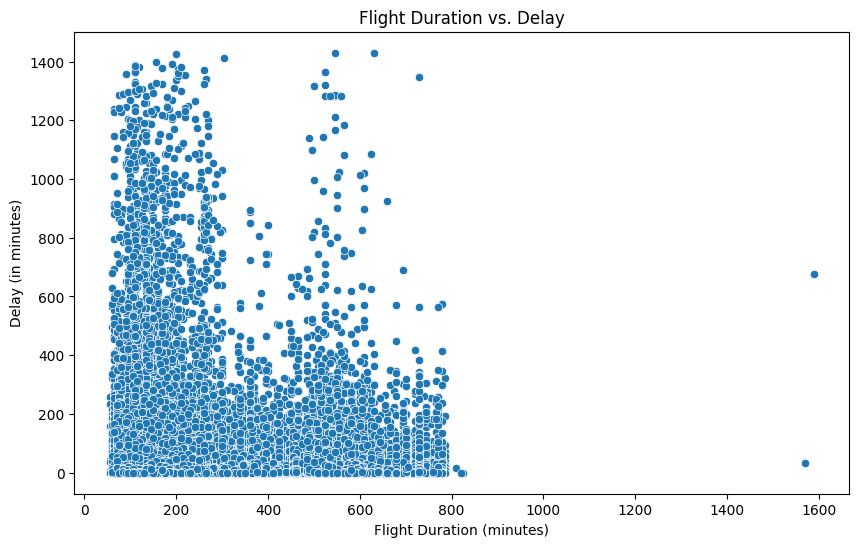

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO

# Функция для загрузки данных
def load_flight_data():
    header = ['Departure Airport', 'Scheduled departure time', 'Destination Airport', 'Scheduled arrival time', 'Delay']
    data_url = "https://drive.google.com/uc?id=1IP_FHQ_UpNILDBkJp12QzgMjPtHW1bsT"
    raw_df = pd.read_csv(data_url, names=header, skiprows=1)
    return raw_df

# Загрузка данных
data = load_flight_data()

# Преобразование временных меток в datetime формат
data['Scheduled departure time'] = pd.to_datetime(data['Scheduled departure time'])
data['Scheduled arrival time'] = pd.to_datetime(data['Scheduled arrival time'])

# Рассчитаем продолжительность рейса (в минутах)
data['Flight duration'] = (data['Scheduled arrival time'] - data['Scheduled departure time']).dt.total_seconds() / 60.0

# Добавим столбец с годом вылета для разделения данных
data['Departure year'] = data['Scheduled departure time'].dt.year

# Разделим данные на обучающие (2015-2017) и тестовые (2018)
train_data = data[data['Departure year'] < 2018]
test_data = data[data['Departure year'] == 2018]

# Убедимся в корректности разделения
print(f"Train data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

# Визуализация продолжительности рейса и задержки
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['Flight duration'], y=train_data['Delay'])
plt.xlabel('Flight Duration (minutes)')
plt.ylabel('Delay (in minutes)')
plt.title('Flight Duration vs. Delay')
plt.show()

Обнаружение и удаление выбросов

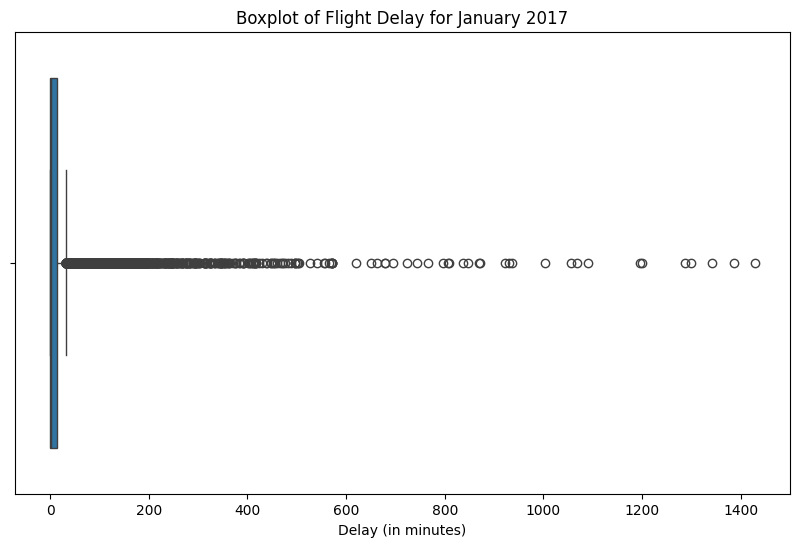

Количество данных до удаления выбросов: 18505
Количество данных после удаления выбросов: 16253


In [ ]:
# Фильтрация данных за январь 2015 года
data_january = data[(data['Scheduled departure time'].dt.year == 2017) & (data['Scheduled departure time'].dt.month == 1)]

# Визуализация задержки рейсов (Delay) с помощью диаграммы размаха
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_january['Delay'])
plt.xlabel('Delay (in minutes)')
plt.title('Boxplot of Flight Delay for January 2017')
plt.show()

# Расчет квартилей и межквартильного размаха (IQR)
Q1 = data_january['Delay'].quantile(0.25)
Q3 = data_january['Delay'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для выявления выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтрация выбросов
data_without_outliers = data_january[(data_january['Delay'] >= lower_bound) & (data_january['Delay'] <= upper_bound)]

# Сравнение количества данных до и после удаления выбросов
print(f"Количество данных до удаления выбросов: {data_january.shape[0]}")
print(f"Количество данных после удаления выбросов: {data_without_outliers.shape[0]}")


Модели машинного обучения и Измерение производительности

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Линейная регрессия
linear_model = LinearRegression()
mae, mse, rmse = evaluate_model(linear_model, X_train, y_train, X_test, y_test)
print(f"Linear Regression - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Полиномиальная регрессия (степень 2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
mae, mse, rmse = evaluate_model(poly_model, X_train, y_train, X_test, y_test)
print(f"Polynomial Regression (degree 2) - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Lasso регрессия
lasso_model = Lasso(alpha=0.1)
mae, mse, rmse = evaluate_model(lasso_model, X_train, y_train, X_test, y_test)
print(f"Lasso Regression - MAE: {mae}, MSE: {mse}, RMSE: {rmse}")


Linear Regression - MAE: 14.4016518412663, MSE: 1619.2068848222061, RMSE: 40.23936983629597
Polynomial Regression (degree 2) - MAE: 14.391487605431013, MSE: 1618.815791296427, RMSE: 40.234509954719556
Lasso Regression - MAE: 14.401699468613385, MSE: 1619.20746051902, RMSE: 40.23937698969779
